In [42]:
from time import perf_counter as pc

import numpy as np

from matplotlib import pyplot as plt, cm, colors

import torch
from torch import tensor, nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
torch.__version__

'1.13.0+cu117'

I borrow code and ideas from

- ["Understanding Generalization through Visuzalizations"](https://arxiv.org/abs/1906.03291) (Huang et al, 2019) in their repository [`wronnyhuang/gen-viz`](https://github.com/wronnyhuang/gen-viz)
- ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/abs/1712.09913) (Li et al, 2018) in their repository [`tomgoldstein/loss-landscape`](https://github.com/tomgoldstein/loss-landscape)

# Abstract

This project examines neural network loss surfaces not just as functions of weights—in "weightspace"—but also as functions of data—in "dataspace." While more work remains to be done, it's a first go at creating these loss surfaces in dataspace and then comparing them with those in weightspace. The goal of this comparison is to verify the claim that "flat minimizers" (in weightspace) generalize better than "sharp" ones, by checking whether these flat minimizers in weightspace correspond to flat minimizers in "dataspace," which more immediately correspond to better generalization.

# Background

A common belief in deep learning literature and culture is that so-called "flat minimizers" generalize better. What is meant by this?

First, some background. If one plots the loss of a model over its entire training set, one obtains a scalar loss. If one varies the weights of the model, one can obtain the loss over a region of the model's "weightspace." Of course, most models have $n \gg 2$ weight parameters, so this region is extremely high dimensional ($n$-dimensional, in fact) and cannot be visualized unless we perform some kind of projection. A common method of projection is to take two random "directions," each of which matches the dimensions of the model's weights, and then compute the loss on a mesh of points containing the found minimizer and the two directions. This creates a two-dimensional "parameter-space," and then the loss can be plotted on a third dimension, yielding a "loss surface."

Now to discuss the "flat minimizer." By this one means that the loss surface described above has more of a flat basin around the minimizer, rather than a sharp valley, so that if one varies the weights slightly, the loss (and, presumably, accuracy) doesn't change much.

The claim is that these "flat minimizers" generalize better to unseen data. After reading more of the literature, I find myself more conviced of this claim. However, the goal of this paper is to examine the loss surface in "dataspace." This, after all, is really what should mean "generalization": if a model has a flat basin in dataspace around the found minimizer, then unseen data—which we hope lives in a small neighborhood around the training data, since it ought to originate from the same distribution—should result in loss similar to that obtained when training, and thus comparable accuracy as well.

So, if we can find that flat minimizers in weightspace correlate with flat minimizers in dataspace, we will have more visual evidence for the claim that flat minimizers in weightspace generalize better. To that end, this paper will create loss surface plots in both weightspace and dataspace for regular data and then, following Huang et al., will attempt to "poison" the data to artificially create poor—sharp—minimizers, and compare the weightspace and dataspace plots.

# Related Work

In 2016, Keskar et al. found that larger batch sizes led to sharper minimizers (in weightspace) and higher generalization error. Then in 2017, Dinh et al. found that neural networks can be reparametrized arbitrarily, yielding the same function but different loss surfaces. For example, in ReLU-activated networks, one can double the weights in one layer and halve the weights in the next to obtain same result. This conclusion, if unaddressed, would make it much more difficult if even possible to compare networks by examining loss surfaces. Fortunately, Li et al. in 2017 determined that one can scale the "weight" directions to have the same norm as corresponding weights in the network, yielding a scaling of weightspace that would then allow comparison between networks.

Later, in 2019, Huang et al. reasoned that flat minimizers generalize better because they have larger margins between data points and decision boundaries, since a small variation in weights—moving the decision boundary—changes fewer classifications of data points. This would correspond to better generalization since test points are more likely to be on the correct sides of decision surfaces.

They also found, through poisoning their data, that sharp minimizers are common, but stochastic gradient descent (SGD) methods prefer flat minimizers since SGD tends toward the large "volume" of the basin around the minimizer.

In this paper I follow Huang et al. in training on a simple "swiss roll" dataset and in plotting loss surfaces. I also adapt Li et al.'s method of scaling weight directions to scaling "data directions."

# Method

I create a regular "swiss roll" dataset as well as a "poisoned" one with samples that are mislabeled. The goal is to obtain 100% training accuracy on the poisoned dataset, as this would indicate overfitting and poor generalization. Unfortunately, even after varying the size of the dataset, the proportion of the poison samples, upsampling the poison samples (i.e., creating copies of them so they receive more weight when training), varying hyperparameters and even trying different model architectures (batch-normalization, layer-normalization, residual connections), I was only able to obtain 94.7% accuracy on the poisoned training set with a poison-to-clean ratio of 10% (and poison points upsampled/duplicated by a factor of 3). I'll discuss later how this impacts my results.

As mentioned, I adapt Li et al.'s method of obtaining scaled weight directions. I create a random direction with dimensions matching the training dataset, and then using the training dataset I scale the direction tensor both by norms across features and by norms across data points. I demonstrate both, though it's as yet unclear to me which is more meaningful.

Below I train the unpoisoned and poisoned models, visualize the data and decision boundaries, and create contour plots of the loss surfaces in weightspace and dataspace. Note that in a given cell output the plot colors and associated values are consistent, so that they can be directly compared.

# Define function to create "two spirals" data

In [3]:
### Adapted from `gen-viz`
def twospirals(n_points, noise=0.5, rng=None, bimodal=None):
  """
    Returns the two spirals dataset.

    `bimodal` is useful to set poison data a little further from the distribution of true data,
    so that it's easier to nudge the model to move the decision boundaries.
  """
  if rng is None:
    rng = np.random.default_rng(42)

  if bimodal is None:
    sample = lambda size: rng.uniform(-noise, noise, size=(size, 1))
  else:
    # In this case, `noise` is unused
    μ, σ = bimodal
    sample = lambda size: rng.permutation(np.concatenate((
      rng.normal(μ, σ, size=(size//2, 1)),
      # If size is odd, then two integer divisions will yield one less than n_points
      rng.normal(- μ, σ, size=(size//2 + (1 if size % 2 == 1 else 0), 1))
    )))

  n = np.sqrt(rng.uniform(size=(n_points, 1))) * 600 * (2*np.pi)/360

  d1x = -1.5*np.cos(n)*n + sample(n_points)
  d1y =  1.5*np.sin(n)*n + sample(n_points)

  return (np.vstack((np.hstack((d1x,d1y)), np.hstack((-d1x,-d1y)))),
          np.hstack((np.zeros(n_points), np.ones(n_points))))

# Define Dataset and DataLoaders

In [4]:
class Swissroll(Dataset):
  """
    A Dataset for the points generated by `twospirals`
  """
  def __init__(self, X, Y):
    self.X, self.Y = X, Y
  
  def __len__(self): return len(self.Y)

  def __getitem__(self, idx): return self.X[idx], self.Y[idx]

class DataLoader_(DataLoader):
  """Convenience class that records the number of samples in the dataset."""
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    dataset = args[0]
    self.num_samples = len(dataset)

# Define model

In [5]:
class LinearRes(nn.Module):
  """Fully connected layer with residual/skip connection, implemented through addition
  (rather than concatenation).
  
  Requires that the in-dimension and the out-dimension be the same.
  """

  def __init__(self, *args, **kwargs):
    in_features, out_features = args[:2]
    assert in_features == out_features, f"in_features should be equal to out_features ({in_features} != {out_features})"

    super().__init__()
    self.linear = nn.Linear(*args, **kwargs)

  def forward(self, x):
    return self.linear(x) + x
    
class Model(nn.Module):
  def __init__(self, extra=None, dim=16, num_layers=6, res=False):
    """res: use residual connections between intermediate hidden layers"""

    super().__init__()
    torch.manual_seed(42)

    # This appears to be what Huang et al used
    num_hidden = (23, 16, 26, 32, 28, 31)

    num_hidden = np.full(num_layers, dim)

    act = nn.ReLU()

    def bn(n): return nn.BatchNorm1d(n, affine=False)

    extra_layer = nn.LayerNorm if extra == 'layernorm' \
      else bn if extra == 'batchnorm' \
      else nn.Identity

    # Create ReLU-activation fully connected layers using the hidden dimensions
    if res is False:
      layers = [[nn.Linear(prev, post), extra_layer(post), act] for prev, post in zip(num_hidden[:-1], num_hidden[1:])]
    else:
      layers = [[LinearRes(prev, post), extra_layer(post), act] for prev, post in zip(num_hidden[:-1], num_hidden[1:])]

    layers = sum(layers, [])

    self.seq = nn.Sequential(
      nn.Linear(2, num_hidden[0]), # Input data is two-dimensional
      act,
      *layers,
      nn.Linear(num_hidden[-1], 2) # Two output classes
    )

    # Record the number of parameters for convenience
    self.num_params = sum([p.numel() for p in self.parameters() if p.requires_grad])

    # Declare the attribute here (for use by `self.record_weights` and externally)
    self.weights = None

  def forward(self, X):
    return self.seq(X)
  
  # Inspired by `gen-viz`
  def infer(self, X):
    return torch.argmax(self(X), axis=1)

  # Record the weights at a specific point in time as a reference
  def record_weights(self): self.weights = [p.data for p in self.parameters()]

  def reset_weights(self):
    """Reset the weights to those recorded in `self.weights`"""
    if self.weights is not None:
      for p, w in zip(self.parameters(), self.weights):
        p.data = w
  
print(f"number of parameters: {Model().num_params}")

number of parameters: 1442


# Define train and test loops

In [6]:
def train(model, opt, num_epochs, train_loader, print_every=10, scheduler=None):
  obj = nn.CrossEntropyLoss()
  model.train()

  # Use a different random seed every epoch but in a deterministic order
  seeds = np.arange(num_epochs)

  # Mean loss per sample
  mean_train_losses = [None] * num_epochs
  accs = [None] * num_epochs

  for epoch in range(num_epochs):
    # Set the train_loader shuffle
    train_loader.generator.manual_seed(int(seeds[epoch]))

    epoch_loss = 0
    correct = 0
    for x, y in train_loader:
      x, y = x.to(device), y.to(device)
      opt.zero_grad()

      # Predict, get loss, backprop, step
      pred = model(x)
      loss = obj(pred, y)
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
      correct += torch.sum(torch.argmax(pred, axis=1) == y).item()
    
    if scheduler is not None:
      scheduler.step(epoch_loss)

    # Record mean loss per sample and mean accuracy 
    mean_train_losses[epoch] = epoch_loss / train_loader.num_samples
    accs[epoch] = correct / train_loader.num_samples

    if epoch % print_every == 0:
      print(f"epoch: {epoch:>5} | mean loss: {mean_train_losses[epoch]:.3f} | accuracy: {accs[epoch]:.3f}")
  
  return tensor(mean_train_losses), tensor(accs)

def test(model, test_loader):
  obj = nn.CrossEntropyLoss()
  model.eval()

  loss = 0
  correct = 0
  for x, y in test_loader:
    x, y = x.to(device), y.to(device)

    pred = model(x)

    loss += obj(pred, y).item()
    correct += torch.sum(torch.argmax(pred, axis=1) == y).item()

  mean_test_loss = loss / test_loader.num_samples
  test_acc = correct / test_loader.num_samples

  return mean_test_loss, test_acc

# Define function to plot decision boundary

In [7]:
### Adapted from `gen-viz`
def plot_decision_boundary(model, dataset, xls, yls, ax, shade=""):
  """Predict the classification on a grid of points on a dataset.
  
  Params:
    shade : prepended to "red" or "blue" (e.g., to indicate test set)
  """

  model.eval()

  xx1, xx2 = np.meshgrid(xls, yls)

  xstack = np.column_stack([xx1.ravel(), xx2.ravel()])
  pred = model.infer(tensor(xstack, dtype=torch.float))
  yy = np.reshape(pred, xx1.shape)

  # Plot decision boundary (only if `shade` is "", to avoid coloring the region twice)
  if shade == "":
    ax.contourf(xx1, xx2, yy, alpha=0.5, cmap="rainbow")

  # Plot dataset0
  mask = dataset[:][1] == 1
  alpha = 0.3
  ax.scatter(*dataset[:][0][mask].T, color=f"{shade}red", alpha=alpha * (3 if shade else 1))
  ax.scatter(*dataset[:][0][~mask].T, color=f"{shade}blue", alpha=alpha * (3 if shade else 1))

  ax.set_xlabel('$x$')
  ax.set_ylabel('$y$')

def get_xls_yls(dataset0, dataset1=None):
  """Get x- and y-linspaces. If given two datasets, make sure the linspaces accomodate both."""

  xn = yn = 100

  col = 0
  if dataset1 is not None:
    xls = np.linspace(
      min(dataset0[:][0][:, col].min(), dataset1[:][0][:, col].min()),
      max(dataset0[:][0][:, col].max(), dataset1[:][0][:, col].max()),
      xn
    )

    col = 1
    yls = np.linspace(
      min(dataset0[:][0][:, col].min(), dataset1[:][0][:, col].min()),
      max(dataset0[:][0][:, col].max(), dataset1[:][0][:, col].max()),
      yn
    )
  else:
    col = 0
    xls = np.linspace(dataset0[:][0][:, col].min(), dataset0[:][0][:, col].max(), xn)

    col = 1
    yls = np.linspace(dataset0[:][0][:, col].min(), dataset0[:][0][:, col].max(), yn)

  return xls, yls

# Generate data

In [8]:
N = 200

test_size = 0.1

train_batch_size = 128
test_batch_size = 64

### Create clean data

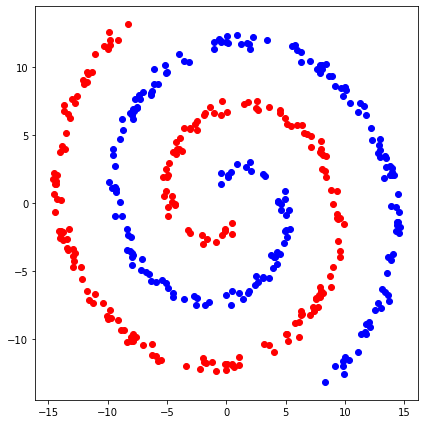

In [9]:
# Generate data and load into dataset
X, Y = twospirals(N)
dataset = Swissroll(tensor(X, dtype=torch.float), tensor(Y, dtype=torch.int64))

# Create random split into train and test sets
train_set, test_set = random_split(dataset, (1 - test_size, test_size), generator=torch.Generator().manual_seed(42))

# Create DataLoaders
train_loader = DataLoader_(train_set, train_batch_size, shuffle=True, generator=torch.Generator())
test_loader = DataLoader_(test_set, test_batch_size, shuffle=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Clean data
ax.scatter(*X[Y == 0].T, color="blue")
ax.scatter(*X[Y == 1].T, color="red")

fig.tight_layout()
fig.show()

### Create poisoned data

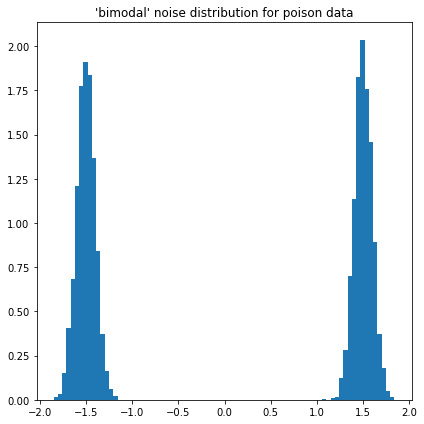

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

μ, σ = 1.5, 0.1
rng = np.random.default_rng()

size = 10000
μ, σ = 1.5, 0.1
sample = rng.permutation(np.concatenate((
  rng.normal(μ, σ, size=size//2),
  rng.normal(- μ, σ, size=size//2)
)))

ax.hist(sample, bins=80, density=True)
ax.set_title("'bimodal' noise distribution for poison data")

fig.tight_layout()
fig.show()

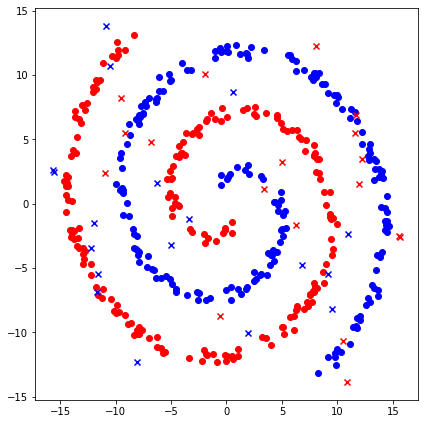

In [36]:
# The proportion of poison points, vs (1 - poison_fraction) portion of clean training points
poison_fraction = 0.1

# Upsample the poison points by this factor, thus increasing the weight of poison points.
# (Include each poison point this many times. If a fraction, then some poison points will
# be included one less time than others.)
poison_upsample_factor = 3

# Scale the number of poisoned samples by the train size, (1 - test_size),
# and by `poison_fraction`.
xp, yp = twospirals(int(N * (1 - test_size) * poison_fraction), bimodal=(1.5, 0.1))
yp = 1 - yp

xp, yp = torch.tensor(xp, dtype=torch.float), torch.tensor(yp, dtype=torch.int64)

# Upsample the poison points
Xp = torch.cat([xp for _ in range(int(poison_upsample_factor))])
Yp = torch.cat([yp for _ in range(int(poison_upsample_factor))])
num_upsample_points = int((poison_upsample_factor - int(poison_upsample_factor)) * len(xp))
Xp = torch.cat((Xp, xp[: num_upsample_points]))
Yp = torch.cat((Yp, yp[: num_upsample_points]))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Clean data
ax.scatter(*X[Y == 0].T, color="blue")
ax.scatter(*X[Y == 1].T, color="red")

# Poisoned data
ax.scatter(*xp[yp == 0].T, color="blue", marker='x')
ax.scatter(*xp[yp == 1].T, color="red", marker='x')

fig.tight_layout()
fig.show()

In [37]:
poison_data = Swissroll(Xp, Yp)

# Concatenate clean_train_set and poisoned dataset (the DataLoader shuffle will mix them)
num_clean = int((1 - poison_fraction) * len(train_set))
ptrain_set = Swissroll(
  torch.cat((train_set[: num_clean][0], poison_data[:][0])),
  torch.cat((train_set[: num_clean][1], poison_data[:][1]))
)

# Create DataLoader
ptrain_loader = DataLoader_(ptrain_set, train_batch_size, shuffle=True, generator=torch.Generator())

# Train on clean data

In [13]:
num_epochs = 100
lr = 1e-2
model = Model().to(device)
opt = optim.Adam(model.parameters(), lr=lr)

mean_train_losses, train_accs = train(model, opt, num_epochs, train_loader, print_every=10)

mean_test_loss, test_acc = test(model, test_loader)

model.record_weights()

epoch:     0 | mean loss: 0.006 | accuracy: 0.506
epoch:    10 | mean loss: 0.005 | accuracy: 0.589
epoch:    20 | mean loss: 0.004 | accuracy: 0.636
epoch:    30 | mean loss: 0.003 | accuracy: 0.881


epoch:    40 | mean loss: 0.001 | accuracy: 0.978
epoch:    50 | mean loss: 0.001 | accuracy: 1.000
epoch:    60 | mean loss: 0.001 | accuracy: 0.992
epoch:    70 | mean loss: 0.000 | accuracy: 1.000
epoch:    80 | mean loss: 0.000 | accuracy: 1.000
epoch:    90 | mean loss: 0.000 | accuracy: 1.000


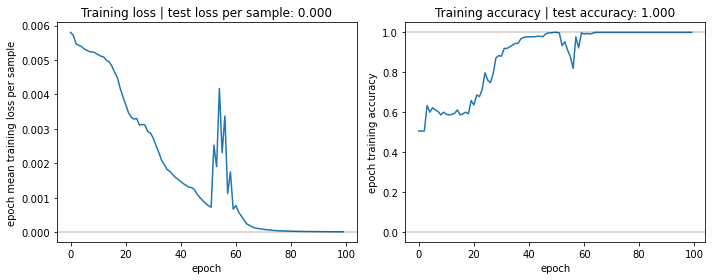

In [14]:
# Plot loss and accuracy to show model is learning
# Test loss and accuracy indicate model generalizes well
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.plot(mean_train_losses)
ax.set_xlabel("epoch")
ax.set_ylabel("epoch mean training loss per sample")
ax.set_title(f"Training loss | test loss per sample: {mean_test_loss:.3f}")
ax.axhline(0, color="black", alpha=0.2)

ax = axs[1]
ax.plot(train_accs)
ax.set_xlabel("epoch")
ax.set_ylabel("epoch training accuracy")
ax.set_title(f"Training accuracy | test accuracy: {test_acc:.3f}")
ax.axhline(0, color="black", alpha=0.2)
ax.axhline(1, color="black", alpha=0.2)

fig.tight_layout()
fig.show()

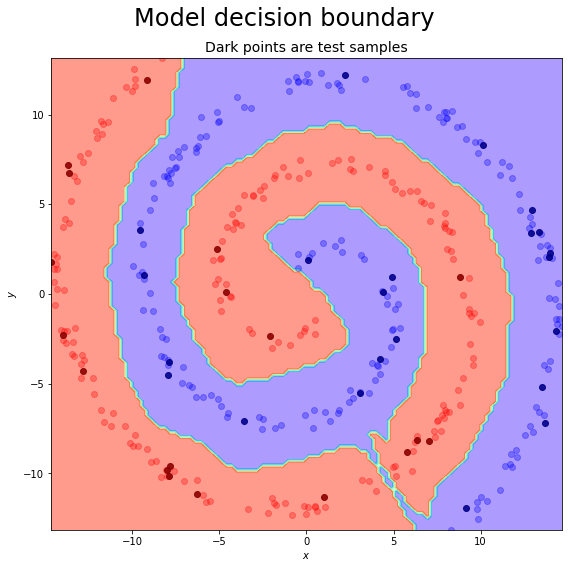

In [15]:
model.eval()

xls, yls = get_xls_yls(train_set, test_set)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

plot_decision_boundary(model, train_set, xls, yls, ax)
plot_decision_boundary(model, test_set, xls, yls, ax, "dark")

fig.suptitle("Model decision boundary", fontsize=24)
ax.set_title("Dark points are test samples", fontsize=14)

fig.tight_layout()
fig.show()

# Train on poisoned data

In [38]:
num_epochs = 300
lr = 1e-2
pmodel = Model(dim=16 * 3, num_layers=6 * 4, res=True).to(device)
opt = optim.Adam(pmodel.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, cooldown=50, verbose=True)

mean_train_losses, train_accs = train(pmodel, opt, num_epochs, ptrain_loader, print_every=10, scheduler=scheduler)

mean_test_loss, test_acc = test(pmodel, test_loader)

pmodel.record_weights()

epoch:     0 | mean loss: 0.906 | accuracy: 0.472
epoch:    10 | mean loss: 0.006 | accuracy: 0.542
epoch:    20 | mean loss: 0.006 | accuracy: 0.560
epoch:    30 | mean loss: 0.006 | accuracy: 0.641
epoch:    40 | mean loss: 0.006 | accuracy: 0.729
epoch:    50 | mean loss: 0.006 | accuracy: 0.648
epoch:    60 | mean loss: 0.005 | accuracy: 0.766
epoch:    70 | mean loss: 0.005 | accuracy: 0.764
epoch:    80 | mean loss: 0.005 | accuracy: 0.738
epoch:    90 | mean loss: 0.005 | accuracy: 0.722
epoch:   100 | mean loss: 0.004 | accuracy: 0.796
epoch:   110 | mean loss: 0.004 | accuracy: 0.782
epoch:   120 | mean loss: 0.005 | accuracy: 0.782
Epoch 00126: reducing learning rate of group 0 to 1.0000e-03.
epoch:   130 | mean loss: 0.004 | accuracy: 0.845
epoch:   140 | mean loss: 0.003 | accuracy: 0.875
epoch:   150 | mean loss: 0.003 | accuracy: 0.882
epoch:   160 | mean loss: 0.003 | accuracy: 0.894
epoch:   170 | mean loss: 0.002 | accuracy: 0.903
epoch:   180 | mean loss: 0.002 | accu

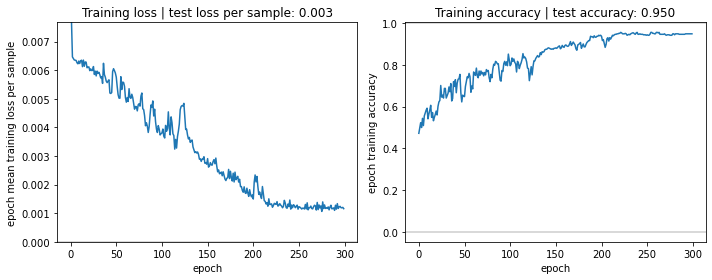

In [39]:
# Plot loss and accuracy to show model is learning
# Test loss and accuracy indicate model generalizes well
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
ax.plot(mean_train_losses)

# The first epoch can have high loss. Restrict the window to show detail of later epochs.
ax.set_ylim(0, mean_train_losses[1:].max())
ax.set_xlabel("epoch")
ax.set_ylabel("epoch mean training loss per sample")
ax.set_title(f"Training loss | test loss per sample: {mean_test_loss:.3f}")
ax.axhline(0, color="black", alpha=0.2)

ax = axs[1]
ax.plot(train_accs)
ax.set_xlabel("epoch")
ax.set_ylabel("epoch training accuracy")
ax.set_title(f"Training accuracy | test accuracy: {test_acc:.3f}")
ax.axhline(0, color="black", alpha=0.2)
ax.axhline(1, color="black", alpha=0.2)

fig.tight_layout()
fig.show()

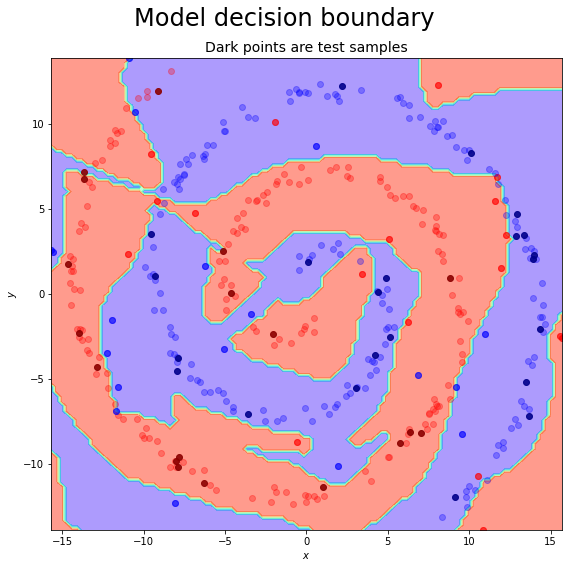

In [41]:
pmodel.eval()

xls, yls = get_xls_yls(ptrain_set, test_set)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

plot_decision_boundary(pmodel, ptrain_set, xls, yls, ax)
plot_decision_boundary(pmodel, test_set, xls, yls, ax, "dark")

fig.suptitle("Model decision boundary", fontsize=24)
ax.set_title("Dark points are test samples", fontsize=14)

fig.tight_layout()
fig.show()

# Define helper functions for weightspace and dataspace plots

- get cax to add colorbar
- get loss on an entire dataset for current weights
- get the min and max on multiple sets of losses

In [19]:
def get_cax(fig, ax, pad, width):
  """Get cax for adding a colorbar."""
  cax = fig.add_axes((
    ax.get_position().x1 + pad,
    ax.get_position().y0,
    width,
    ax.get_position().height
  ))
  return cax

def eval_on_loader(model, loader):
  """Get the loss on the entire dataset in `loadaer`."""
  obj = nn.CrossEntropyLoss()
  model.eval()
  
  loss = 0
  for x, y in loader:
    x, y = x.to(device), y.to(device)

    # Predict, get loss, backprop, step
    pred = model(x)

    loss += obj(pred, y)
  
  return loss.item() / loader.num_samples

def get_min_max(*loglosses):

  f = np.min
  minn = min(map(lambda losses: f(losses), loglosses))

  f = np.max
  maxx = max(map(lambda losses: f(losses), loglosses))

  return minn, maxx

## Define helper functions for weightspace plots

- get random weight directions
- scale weight directions
- set model weights
- get loss on an entire dataset over region in weight space
- plot loss on train and test sets over region in weight space

In [20]:
### Adapted from `loss-landscape`
def get_random_dir_weights(weights, rng):
  """
    Produce a random direction that is a list of random Gaussian tensors
    with the same shape as the network's weights, so one direction entry per weight.
  """
  return [torch.randn(w.size(), generator=rng) for w in weights]

def get_2_random_dirs_weights(weights, rng):
  return [get_random_dir_weights(weights, rng) for _ in range(2)]

### Adapted from `loss-landscape`
def scale_dirs_weights(weights, dirs):
  """
    Set bias directions to zero (`loss-landscape` does this in their example code).
    Scale directions to have norm equal to that of the corresponding layer's weights.
  """
  for dir_i in dirs:
    for d, w in zip(dir_i, weights):
      if d.dim() <= 1:
        # Ignore biases by setting their directions to zero.
        d.fill_(0)
      else:
        d.mul_(w.norm() / d.norm())

### Adapted from `loss-landscape`
def set_weights(model, dirs, steps):
  """
    Set the weights of the model a step in each direction, i.e.,
    (new_weights = original_weights + step * direction) where original_weights
    is the value set at a given point in time by calling model.record_weights().
  """
  model.eval()

  changes = [d0 * steps[0] + d1 * steps[1] for (d0, d1) in zip(*dirs)]

  for (p, w, change) in zip(model.parameters(), model.weights, changes):
    p.data = w + change

def get_loss_surface_weightspace(model, loader, dirs, xn=50, yn=50):
  """Get the grid of loss values on the entire dataset in `loader`."""

  model.eval()

  n = xn * yn
  xls = np.linspace(-1, 1, xn)
  yls = np.linspace(-1, 1, yn)

  xsteps, ysteps = np.meshgrid(xls, yls)
  xis, yis = np.meshgrid(np.arange(xn), np.arange(yn))

  losses = np.full((yn, xn), np.inf)

  # Set the random seed of the loader even though shouldn't be necessary when using entire loader
  if loader.generator is not None:
    loader.generator.manual_seed(42)

  # xstep and ystep are the amount to step in the x- and y- weight directions
  # xi and yi are the indices in the grid of points
  for i, (xstep, ystep, xi, yi) in enumerate(zip(*map(np.ravel, (xsteps, ysteps, xis, yis)))):
    if i % 500 == 0:
      print(f"{i:>5} / {n}")
    
    set_weights(model, dirs, (xstep, ystep))

    losses[yi, xi] = eval_on_loader(model, loader)

  return xsteps, ysteps, losses

def plot_loss_surfaces_weightspace(logtrain_losses, logtest_losses, xsteps, ysteps, norm, title):
  """Plot the loss surfaces in weightspace on the train and test set."""

  model.eval()

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))
  
  cmap = cm.magma

  ax = axs[0]
  contour = ax.contourf(xsteps, ysteps, logtrain_losses, levels=50, norm=norm, cmap=cmap)
  ax.set_title("train")

  ax = axs[1]
  contour = ax.contourf(xsteps, ysteps, logtest_losses, levels=50, norm=norm, cmap=cmap)
  ax.set_title("test")

  [ax.set_aspect("equal") for ax in axs]

  fig.suptitle(title, fontsize=30)
  fig.tight_layout()

  # Place the colorbar.
  pad, width = 0.02, 0.05
  cax = get_cax(fig, axs[1], pad, width)
  fig.colorbar(contour, cax=cax)

  fig.show()

## Define helper functions for dataspace plots

- get random data directions
- scale data directions
- create pertubed dataset using directions and steps
- create pertubed dataloader using directions and steps
- get loss on an entire (potentially perturbed) dataset
- plot loss on entire dataset, perturbed in two random directions

In [21]:
def get_random_dir_data(dataset, rng):
  """Create a random direction that is the same shape as the dataset,
  so one entry per scalar value."""

  return torch.randn(dataset[:][0].size(), generator=rng)

def get_2_random_dirs_data(dataset, rng):
  return [get_random_dir_data(dataset, rng) for _ in range(2)]

def scale_dirs_data(dataset, dirs, dim):
  """
    Inspired Li et al, scale the random dataspace directions.

    dim = 0 : scale by feature:
      e.g., if data has x- and y-coordinates (i.e. is two-dimensional),
        scale the x-coordinates of the direction to have the same norm as the x-coordinates
        of the data, and
        scale the y-coordinates of the direction to have the same norm as the y-coordinates
        of the data
    dim = 1 : scale by datapoint:
      e.g., if their are 3 samples,
        scale the direction corresponding to the first sample to have the same norm as the
        first sample in the data,
        scale the direction corresponding to the second sample to have the same norm as the
        second sample in the data, and
        do the same for third direction/sample
    dim = -1 (or anything else): do nothing
  """
  for dir_i in dirs:
    if dim == 0:
      dir_i.mul_(dataset[:][0].norm(dim=dim) / dir_i.norm(dim=dim))
    elif dim == 1:
      # Note the tranpsose to make the dimensions behave
      dir_i.T.mul_(dataset[:][0].norm(dim=dim) / dir_i.norm(dim=dim))

def get_perturbed_dataset(dataset, dirs, steps):
  """Create a new dataset by perturbing the original in the given directions and 
  by the given steps."""
  
  data = dataset[:][0]

  perturbed_data = data + dirs[0] * steps[0] + dirs[1] * steps[1]
  perturbed_dataset = Swissroll(perturbed_data, dataset[:][1])

  return perturbed_dataset

def get_perturbed_loader(dataset, dirs, steps, batch_size):
  """Create a new dataloader by perturbing the original in the given directions and 
  by the given steps."""

  perturbed_dataset = get_perturbed_dataset(dataset, dirs, steps)
  perturbed_loader = DataLoader_(perturbed_dataset, batch_size, shuffle=False)

  return perturbed_loader

def get_loss_surface_dataspace(model, dataset, dirs, batch_size=train_batch_size, xn=50, yn=50):
  """Get the grid of loss values on the entire (potentially perturbed) dataset in `loader`."""

  model.eval()

  n = xn * yn
  xls = np.linspace(-1, 1, xn)
  yls = np.linspace(-1, 1, yn)

  xsteps, ysteps = np.meshgrid(xls, yls)
  xis, yis = np.meshgrid(np.arange(xn), np.arange(yn))

  losses = np.full((yn, xn), np.inf)

  for i, (xstep, ystep, xi, yi) in enumerate(zip(*map(np.ravel, (xsteps, ysteps, xis, yis)))):
    if i % 500 == 0:
      print(f"{i:>5} / {n}")
    
    perturbed_loader = get_perturbed_loader(dataset, dirs, (xstep, ystep), batch_size)

    losses[yi, xi] = eval_on_loader(model, perturbed_loader)

  return xsteps, ysteps, losses

def plot_loss_surface_dataspace(logtrain_losses, xsteps, ysteps, norm, title):
  """Plot the loss surfaces in dataspace on the train set (i.e., perturbed in two random directions)."""

  model.eval()

  fig, ax = plt.subplots(1, 1, figsize=(6, 6))

  cmap = cm.magma

  contour = ax.contourf(xsteps, ysteps, logtrain_losses, levels=50, norm=norm, cmap=cmap)

  ax.set_aspect("equal")

  fig.tight_layout()

  # Place colorbar
  pad, width = 0.02, 0.05
  cax = get_cax(fig, ax, pad, width)
  fig.colorbar(contour, cax=cax)
  
  fig.suptitle(title, fontsize=30, y=1.025)
  fig.show()

## Plot loss surfaces in weightspace

### without scaling of directions

In [22]:
rng = torch.Generator().manual_seed(42)

dirs = get_2_random_dirs_weights(model.weights, rng)

pdirs = get_2_random_dirs_weights(pmodel.weights, rng)

xsteps, ysteps, train_losses = get_loss_surface_weightspace(model, train_loader, dirs)
*_, test_losses = get_loss_surface_weightspace(model, test_loader, dirs)

# Note we're using the original (unpoisoned) train set
*_, ptrain_losses = get_loss_surface_weightspace(pmodel, train_loader, pdirs)
*_, ptest_losses = get_loss_surface_weightspace(pmodel, test_loader, pdirs)

# Take logs
logtrain_losses, logtest_losses = np.log(train_losses), np.log(test_losses)
plogtrain_losses, plogtest_losses = np.log(ptrain_losses), np.log(ptest_losses)

norm = colors.Normalize(*get_min_max(logtrain_losses, logtest_losses, plogtrain_losses, plogtest_losses))

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


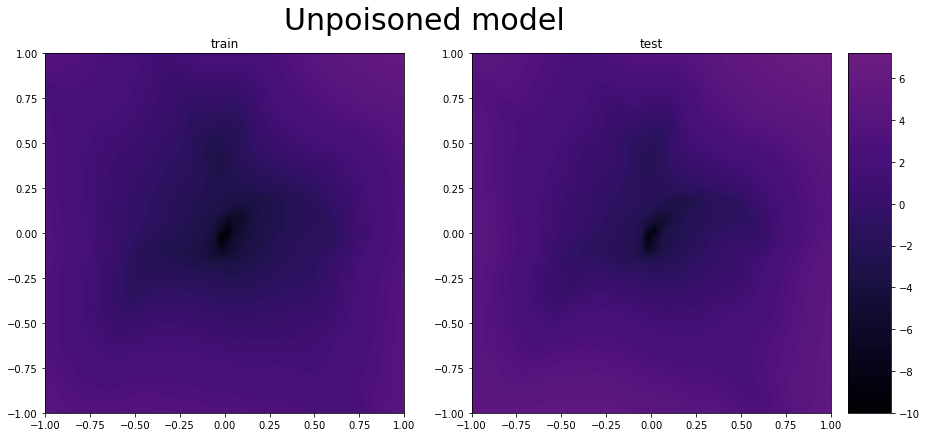

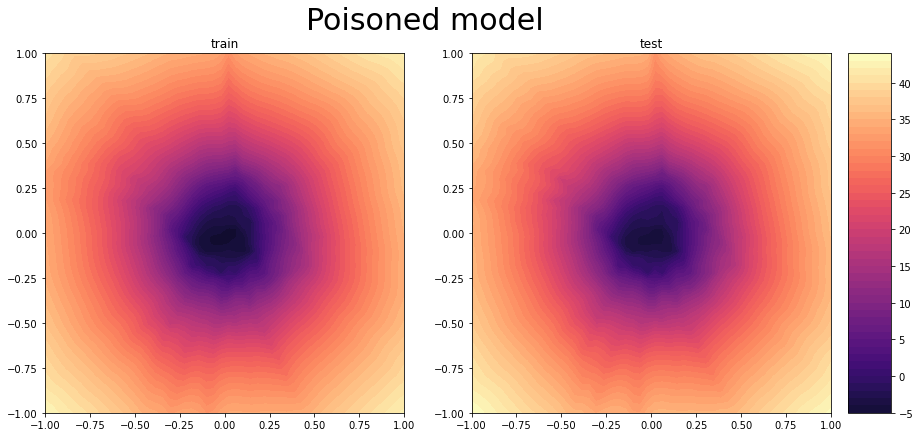

In [23]:
plot_loss_surfaces_weightspace(logtrain_losses, logtest_losses, xsteps, ysteps, norm, "Unpoisoned model")
plot_loss_surfaces_weightspace(plogtrain_losses, plogtest_losses, xsteps, ysteps, norm, "Poisoned model")

### with scaling of directions

In [24]:
rng = torch.Generator().manual_seed(42)

dirs = get_2_random_dirs_weights(model.weights, rng)
scale_dirs_weights(model.weights, dirs)

pdirs = get_2_random_dirs_weights(pmodel.weights, rng)
scale_dirs_weights(pmodel.weights, pdirs)

xsteps, ysteps, train_losses = get_loss_surface_weightspace(model, train_loader, dirs)
*_, test_losses = get_loss_surface_weightspace(model, test_loader, dirs)

# Note we're using the original (unpoisoned) train set
*_, ptrain_losses = get_loss_surface_weightspace(pmodel, train_loader, pdirs)
*_, ptest_losses = get_loss_surface_weightspace(pmodel, test_loader, pdirs)

# Take logs
logtrain_losses, logtest_losses = np.log(train_losses), np.log(test_losses)
plogtrain_losses, plogtest_losses = np.log(ptrain_losses), np.log(ptest_losses)

norm = colors.Normalize(*get_min_max(logtrain_losses, logtest_losses, plogtrain_losses, plogtest_losses))

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


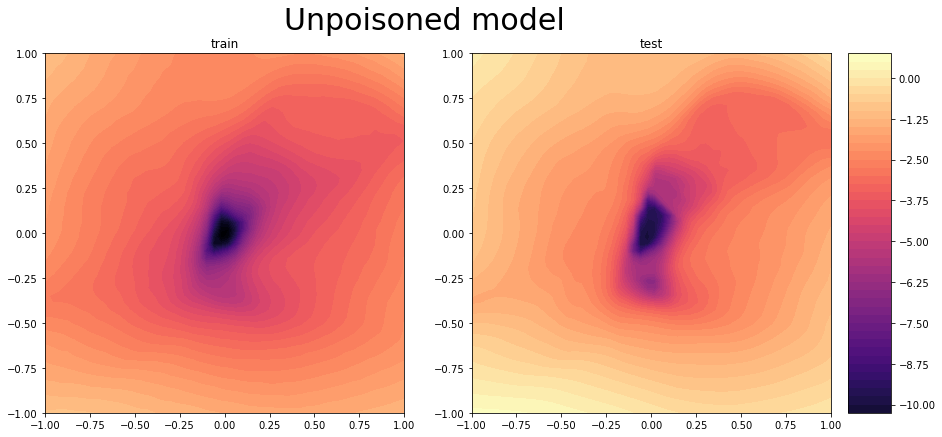

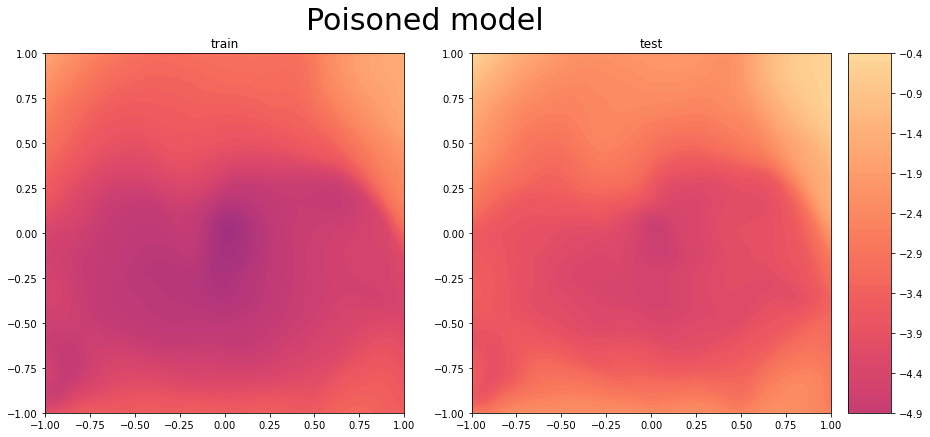

In [25]:
plot_loss_surfaces_weightspace(logtrain_losses, logtest_losses, xsteps, ysteps, norm, "Unpoisoned model")
plot_loss_surfaces_weightspace(plogtrain_losses, plogtest_losses, xsteps, ysteps, norm, "Poisoned model")

## Plot loss surfaces in dataspace

### Without scaling random dataspace directions

In [26]:
dim = -1

model.reset_weights()
pmodel.reset_weights()

rng = torch.Generator().manual_seed(42)

# Note we're using the original (unpoisoned) train set
dirs = get_2_random_dirs_data(train_set, rng)
scale_dirs_data(train_set, dirs, dim=dim)

xsteps, ysteps, train_losses = get_loss_surface_dataspace(model, train_set, dirs)
*_, ptrain_losses = get_loss_surface_dataspace(pmodel, train_set, dirs)

# Take logs
logtrain_losses = np.log(train_losses)
plogtrain_losses = np.log(ptrain_losses)

norm = colors.Normalize(*get_min_max(logtrain_losses, plogtrain_losses))

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


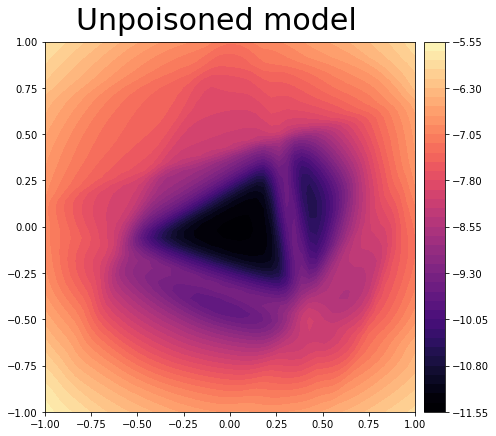

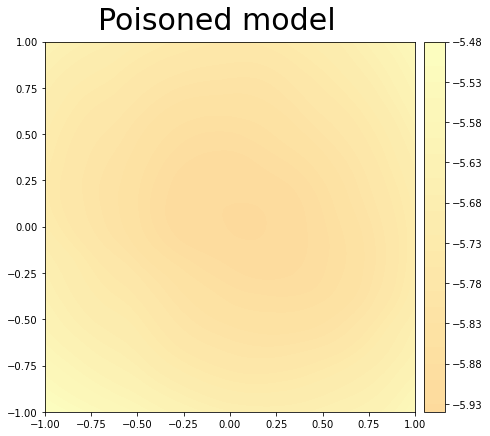

In [27]:
plot_loss_surface_dataspace(logtrain_losses, xsteps, ysteps, norm, "Unpoisoned model")
plot_loss_surface_dataspace(plogtrain_losses, xsteps, ysteps, norm, "Poisoned model")

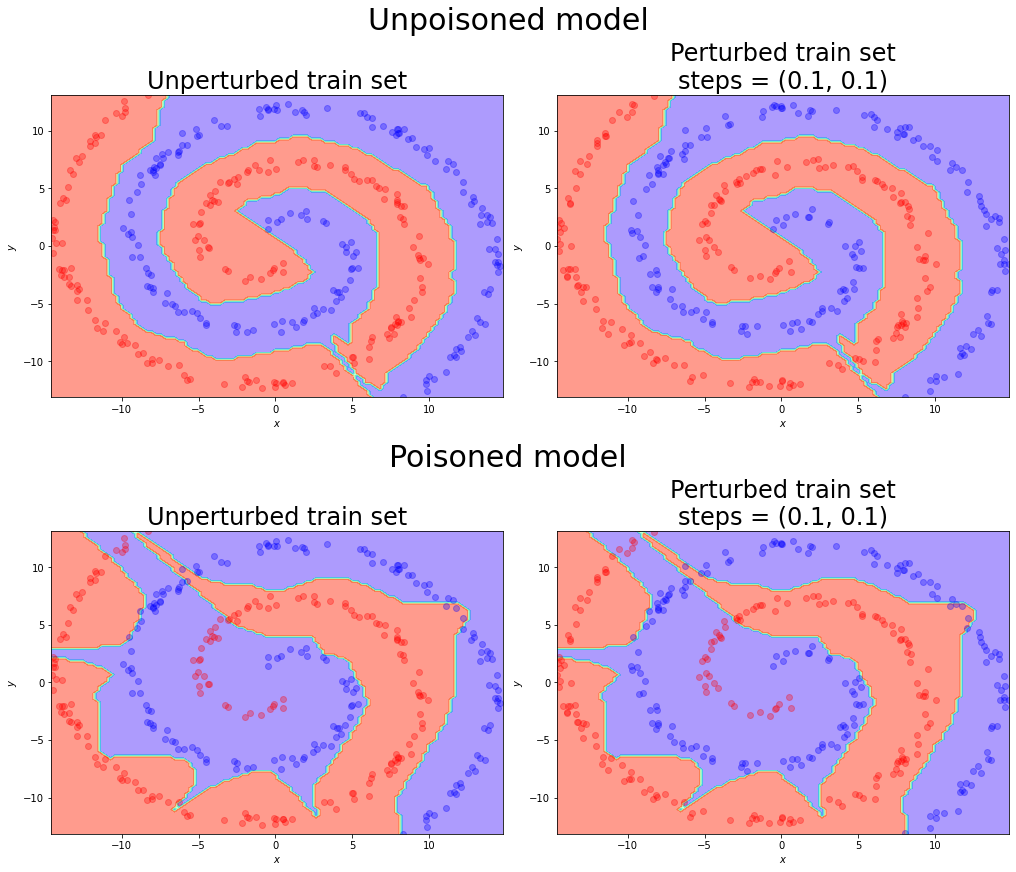

In [28]:
steps = 0.1, 0.1
perturbed_dataset = get_perturbed_dataset(train_set, dirs, steps)

xls, yls = get_xls_yls(train_set, perturbed_dataset)

fig = plt.figure(layout="constrained", figsize=(14, 12))
subfigs = fig.subfigures(2, 1)

# Unpoisoned model
axs = subfigs[0].subplots(1, 2)

ax = axs[0]
plot_decision_boundary(model, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(model, perturbed_dataset, xls, yls, ax)
ax.set_title(f"Perturbed train set\nsteps = {steps}", fontsize=24)

subfigs[0].suptitle("Unpoisoned model", fontsize=30)

# Poisoned model
axs = subfigs[1].subplots(1, 2)

ax = axs[0]
plot_decision_boundary(pmodel, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(pmodel, perturbed_dataset, xls, yls, ax)
ax.set_title(f"Perturbed train set\nsteps = {steps}", fontsize=24)

subfigs[1].suptitle("Poisoned model", fontsize=30)

fig.show()

### With scaling random dataspace directions by features

(see docstring on scale_data_dirs)

In [29]:
dim = 0

model.reset_weights()
pmodel.reset_weights()

rng = torch.Generator().manual_seed(42)

# Note we're using the original (unpoisoned) train set
dirs = get_2_random_dirs_data(train_set, rng)
scale_dirs_data(train_set, dirs, dim=dim)

xsteps, ysteps, train_losses = get_loss_surface_dataspace(model, train_set, dirs)
*_, ptrain_losses = get_loss_surface_dataspace(pmodel, train_set, dirs)

# Take logs
logtrain_losses = np.log(train_losses)
plogtrain_losses = np.log(ptrain_losses)

norm = colors.Normalize(*get_min_max(logtrain_losses, plogtrain_losses))

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


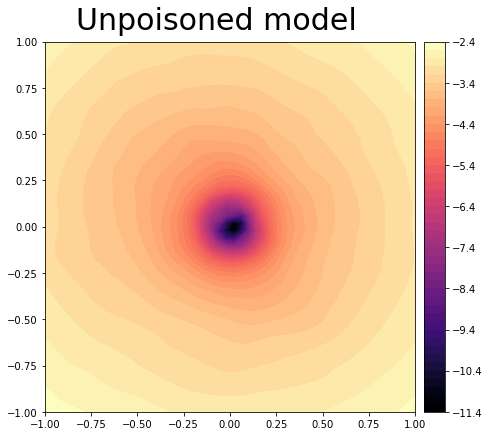

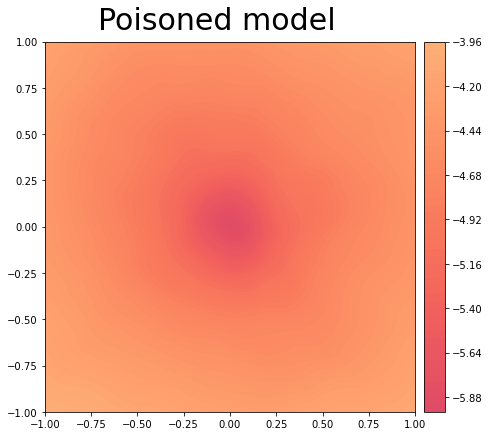

In [30]:
plot_loss_surface_dataspace(logtrain_losses, xsteps, ysteps, norm, "Unpoisoned model")
plot_loss_surface_dataspace(plogtrain_losses, xsteps, ysteps, norm, "Poisoned model")

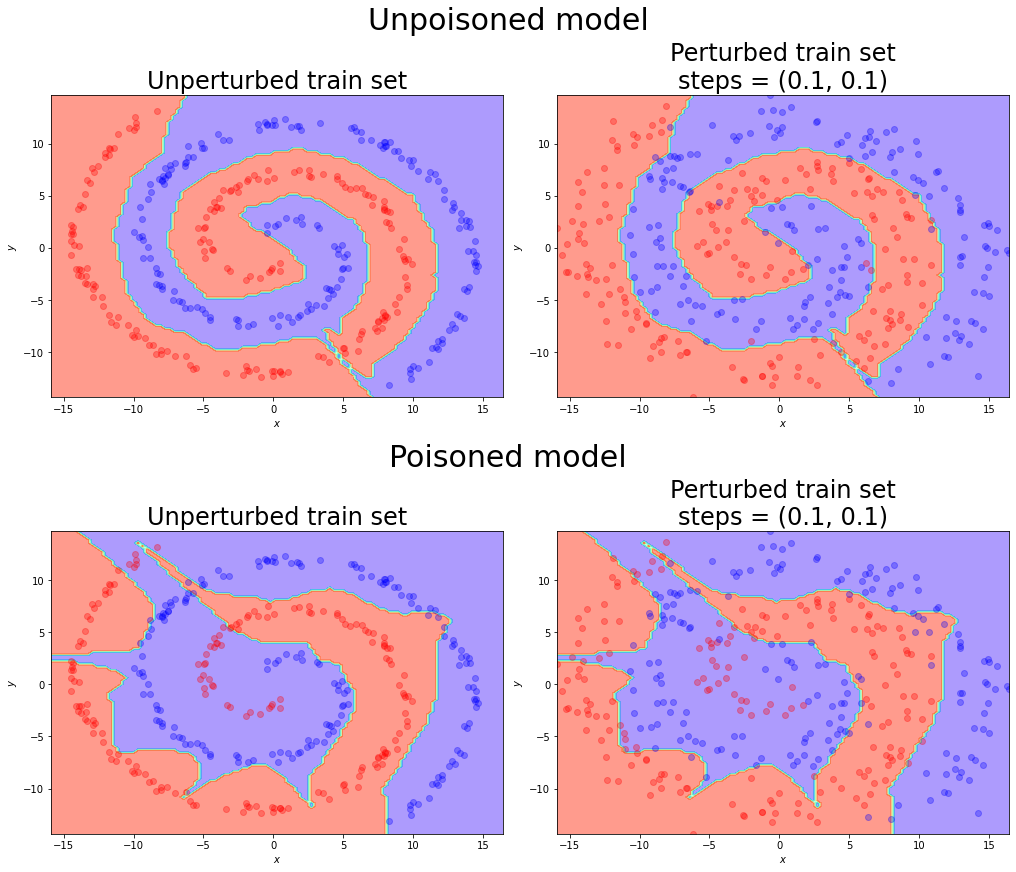

In [31]:
steps = 0.1, 0.1
perturbed_dataset = get_perturbed_dataset(train_set, dirs, steps)

xls, yls = get_xls_yls(train_set, perturbed_dataset)

fig = plt.figure(layout="constrained", figsize=(14, 12))
subfigs = fig.subfigures(2, 1)

# Unpoisoned model
axs = subfigs[0].subplots(1, 2)

ax = axs[0]
plot_decision_boundary(model, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(model, perturbed_dataset, xls, yls, ax)
ax.set_title(f"Perturbed train set\nsteps = {steps}", fontsize=24)

subfigs[0].suptitle("Unpoisoned model", fontsize=30)

# Poisoned model
axs = subfigs[1].subplots(1, 2)

ax = axs[0]
plot_decision_boundary(pmodel, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(pmodel, perturbed_dataset, xls, yls, ax)
ax.set_title(f"Perturbed train set\nsteps = {steps}", fontsize=24)

subfigs[1].suptitle("Poisoned model", fontsize=30)

fig.show()

### With scaling random dataspace directions by datapoints

(see docstring on scale_data_dirs)

In [32]:
dim = 1

model.reset_weights()
pmodel.reset_weights()

rng = torch.Generator().manual_seed(42)

# Note we're using the original (unpoisoned) train set
dirs = get_2_random_dirs_data(train_set, rng)
scale_dirs_data(train_set, dirs, dim=dim)

xsteps, ysteps, train_losses = get_loss_surface_dataspace(model, train_set, dirs)
*_, ptrain_losses = get_loss_surface_dataspace(pmodel, train_set, dirs)

# Take logs
logtrain_losses = np.log(train_losses)
plogtrain_losses = np.log(ptrain_losses)

norm = colors.Normalize(*get_min_max(logtrain_losses, plogtrain_losses))

    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500
    0 / 2500
  500 / 2500
 1000 / 2500
 1500 / 2500
 2000 / 2500


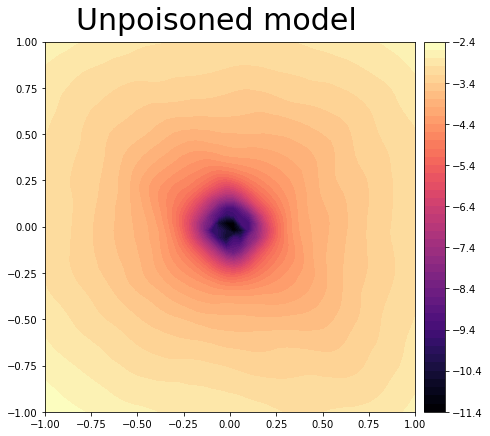

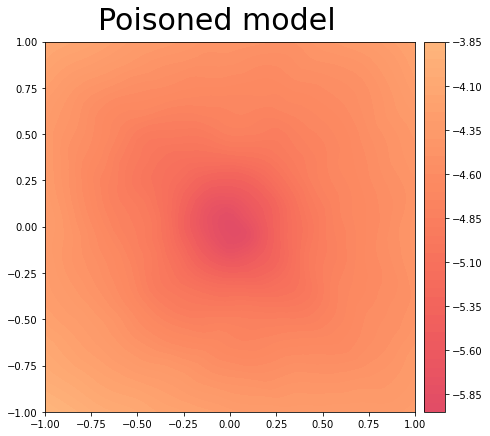

In [33]:
plot_loss_surface_dataspace(logtrain_losses, xsteps, ysteps, norm, "Unpoisoned model")
plot_loss_surface_dataspace(plogtrain_losses, xsteps, ysteps, norm, "Poisoned model")

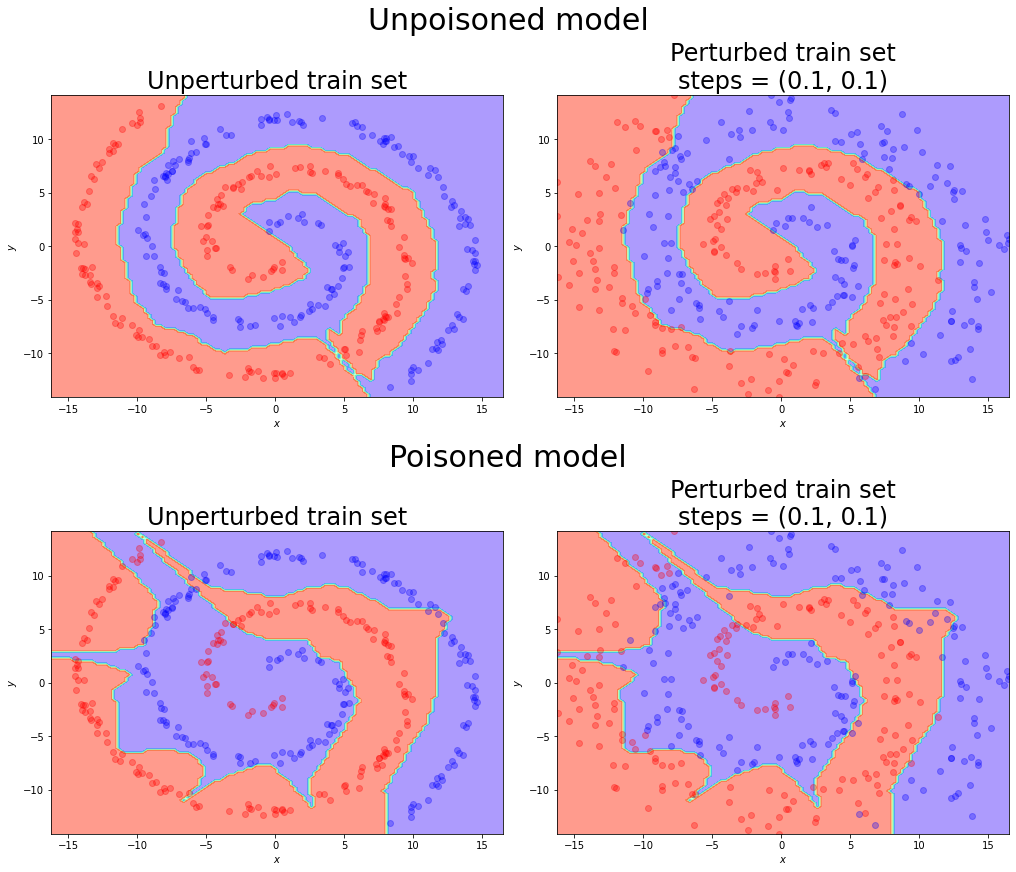

In [34]:
steps = 0.1, 0.1
perturbed_dataset = get_perturbed_dataset(train_set, dirs, steps)

xls, yls = get_xls_yls(train_set, perturbed_dataset)

fig = plt.figure(layout="constrained", figsize=(14, 12))
subfigs = fig.subfigures(2, 1)

# Unpoisoned model
axs = subfigs[0].subplots(1, 2)

ax = axs[0]
plot_decision_boundary(model, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(model, perturbed_dataset, xls, yls, ax)
ax.set_title(f"Perturbed train set\nsteps = {steps}", fontsize=24)

subfigs[0].suptitle("Unpoisoned model", fontsize=30)

# Poisoned model
axs = subfigs[1].subplots(1, 2)

ax = axs[0]
plot_decision_boundary(pmodel, train_set, xls, yls, ax)
ax.set_title("Unperturbed train set", fontsize=24)

ax = axs[1]
plot_decision_boundary(pmodel, perturbed_dataset, xls, yls, ax)
ax.set_title(f"Perturbed train set\nsteps = {steps}", fontsize=24)

subfigs[1].suptitle("Poisoned model", fontsize=30)

fig.show()

# Results and Analysis

As mentioned, the poisoned model did not achieve the same training loss as the unpoisoned one. This makes it difficult to compare the loss surfaces of the unpoisoned and poisoned models in either weightspace or dataspace, since the poisoned model loss surfaces can appear more flat simply because they don't reach as deep of a minimum.

However, it may be of note that in weightspace the loss surfaces of the poisoned model differ less from those of the unpoisoned model, aside from not reaching as deep of a minimum, while in dataspace the loss surfaces of the poisoned model differ drastically from those of the unpoisoned model in the entire region plotted—the loss values are simply much higher everywhere, with little variation aside from a small decrease at the minimizer. It's unclear to me why this should be the case—perhaps a larger region/different scaling of the directions would show more variation, or a finer mesh of points would uncover additional characteristics of the surface.

# Conclusion

Unfortunately, I wasn't able to obtain comparisons that were as meaningful as I hoped. This is, I think, at least in part due to my inability to overfit the model to the poisoned data and obtain perfect training accuracy, as this would have made the loss surfaces more comparable between poisoned and unpoisoned data.

I note here that the intuition from Huang et al.—that flat minimizers in weightspace correspond to wider margins between data points and decision surfaces—is clear and readily visualized on a two-dimensional dataset like the swiss roll. Because this paper focuses on this dataset, it essentially attempts verify what is already obvious in two dimensions. However, this intuition is less obvious in higher dimensions. Thus, future work should not only succeed in producing an overfit model, but should also adapt the process here to a task with higher-dimensional data, where the decision surface intuition isn't obvious—if true at all.

Moreover, I work under the assumption that sharp minimizers in weightspace correspond to decision boundaries that are closer to data points, and thus I attempt to obtain sharper minimizers by poisoning the data with points that move the decision boundaries. However, it's not obvious that this is the only way sharp minimizers occur. Thus, more rigorous empirical work would take models with natural sharp minimizers—not artificially produced—and verify claims about the flatness of minimizers. This would avoid the circularity in logic that occurs here as I attempt to verify that sharp minimizers and poor generalization are correlated when I produce low generalization by artificially creating sharp minimizers.

However, despite these drawbacks to this work, it is hoped that this paper can call attention to a gap in the scientific community's understanding of deep learning—do flat minimizers in weightspace *really* correspond to better generalization, that is, to flat minimizers in dataspace? Additionally, this paper carries out the process of computing loss surfaces in both weightspace and dataspace, hopefully giving later researchers a starting point to work from when applying these methods to larger and more complex datasets and tasks. Future work can also examine what type of scaling of directions in dataspace makes sense.

And lastly, on a personal note, while it was awesome when during this project I plotted my first-ever loss surface in weightspace, it was really awesome when I plotted one in dataspace. Since I was first exposed to the concept of loss surfaces, I've wondered, "But what do they look like as a function of data? After all, they depend heavily on the data. Why does no one try it?" I'm not sure if anyone has tried it, but I haven't been able to find it, so when I plotted it for the first time it felt like crossing a threshold on the frontier of exploration. Pretty neat.

# References

Alain, G., Roux, N. L., & Manzagol, P.-A. (2019). Negative eigenvalues of the Hessian in deep neural networks. CoRR, abs/1902.02366. http://arxiv.org/abs/1902.02366

Dinh, L., Pascanu, R., Bengio, S., & Bengio, Y. (2017). Sharp Minima Can Generalize For Deep Nets. CoRR, abs/1703.04933. http://arxiv.org/abs/1703.04933

Huang, W. R., Emam, Z., Goldblum, M., Fowl, L., Terry, J. K., Huang, F., & Goldstein, T. (2019). Understanding Generalization through Visualizations. CoRR, abs/1906.03291. http://arxiv.org/abs/1906.03291

Ideami, J. (n.d.). Learn about how the A.I, deep learning loss landscape project works. Landscape. Retrieved April 19, 2024, from https://losslandscape.com/faq/

Keskar, N. S., Mudigere, D., Nocedal, J., Smelyanskiy, M., & Tang, P. T. P. (2016). On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima. CoRR, abs/1609.04836. http://arxiv.org/abs/1609.04836

Li, H., Xu, Z., Taylor, G., & Goldstein, T. (2017). Visualizing the Loss Landscape of Neural Nets. CoRR, abs/1712.09913. http://arxiv.org/abs/1712.09913